In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import scipy.io
import numpy as np

In [2]:
def load_mat_data(train_data_path, test_data_path):
    # 加载训练数据
    train_mat = scipy.io.loadmat(train_data_path)
    train_data = np.array(train_mat['train_data_5'], dtype='float32')
    train_labels = np.array(train_mat['train_label_5'], dtype='float32').squeeze()  # 从2D转换为1D
    
    # 加载测试数据
    test_mat = scipy.io.loadmat(test_data_path)
    test_data = np.array(test_mat['test_data_5'], dtype='float32')
    test_labels = np.array(test_mat['test_label_5'], dtype='float32').squeeze()  # 从2D转换为1D
    
    return train_data, train_labels, test_data, test_labels

# 设置数据路径
train_data_path = '/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/database/train_5.mat'
test_data_path = '/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/database/test_5.mat'

# 加载数据
train_data, train_labels, test_data, test_labels = load_mat_data(train_data_path, test_data_path)

# 因为1D CNN需要一个额外的维度，我们将数据重塑
train_data = train_data.reshape((-1, 3072, 1))
test_data = test_data.reshape((-1, 3072, 1))

# 对数据进行归一化处理
train_data /= np.max(train_data)
test_data /= np.max(test_data)

print('Train data shape:', train_data.shape)
print('Train labels shape:', train_labels.shape)
print('Test data shape:', test_data.shape)
print('Test labels shape:', test_labels.shape)



Train data shape: (18000, 3072, 1)
Train labels shape: (18000,)
Test data shape: (2000, 3072, 1)
Test labels shape: (2000,)


In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2
import math

# 学习率衰减函数
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

model = models.Sequential([
    layers.Reshape((32, 96, 1), input_shape=(3072,)),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),  # 增加Dropout比率
    
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),  # 增加Dropout比率

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.Flatten(),
    layers.Dropout(0.75),  # 进一步增加Dropout比率
    layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dropout(0.5),  # 在全连接层之后也使用Dropout
    layers.Dense(10, activation='softmax')
])

# 使用Adam优化器，并设置一个初始学习率
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 32, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 30, 94, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 13, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 22, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 6, 22, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 20, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       655,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 749,130 (2.86 MB)

 Trainable params: 748,938 (2.86 MB)

 Non-trainable params: 192 (768.00 B)

In [5]:
# 调整fit函数，加入LearningRateScheduler和EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(train_data, train_labels, epochs=20, 
                    validation_data=(test_data, test_labels),
                    callbacks=[callbacks_list, early_stopping])



Epoch 1/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 28s 48ms/step - accuracy: 0.2153 - loss: 2.3755 - val_accuracy: 0.1000 - val_loss: 6.8808 - learning_rate: 0.0010
Epoch 2/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 29s 51ms/step - accuracy: 0.3456 - loss: 1.7656 - val_accuracy: 0.5135 - val_loss: 1.3632 - learning_rate: 0.0010
Epoch 3/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 31s 55ms/step - accuracy: 0.4173 - loss: 1.5508 - val_accuracy: 0.5060 - val_loss: 1.2120 - learning_rate: 0.0010
Epoch 4/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 32s 57ms/step - accuracy: 0.4447 - loss: 1.4537 - val_accuracy: 0.5430 - val_loss: 1.2376 - learning_rate: 0.0010
Epoch 5/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 31s 55ms/step - accuracy: 0.4766 - loss: 1.3640 - val_accuracy: 0.5905 - val_loss: 1.0573 - learning_rate: 0.0010
Epoch 6/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 30s 53ms/step - accuracy: 0.4965 - loss: 1.2656 - val_accuracy: 0.5760 - val_loss: 1.0228 - learning_rate: 0.0010
Epoch 7/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 30s 53ms/step - accuracy: 0.5224 - l

In [6]:
# 在测试集上评估模型
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)


63/63 - 1s - 11ms/step - accuracy: 0.5315 - loss: 0.9771

Test accuracy: 0.531499981880188


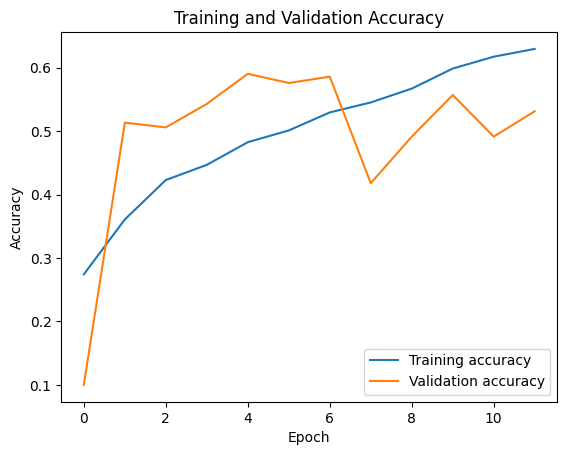

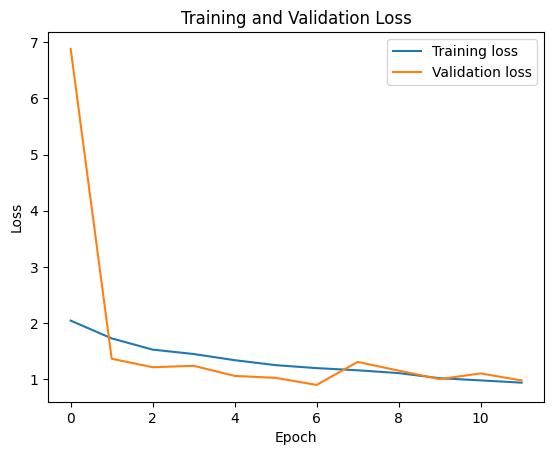

In [7]:
# 可视化训练过程
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
              precision    recall  f1-score   support

           0       0.27      0.10      0.15       200
           1       1.00      1.00      1.00       200
           2       0.00      0.00      0.00       200
           3       0.29      1.00      0.45       200
           4       1.00      1.00      1.00       200
           5       1.00      0.71      0.83       200
           6       0.53      1.00      0.69       200
           7       1.00      0.49      0.66       200
           8       0.00      0.00      0.00       200
           9       0.01      0.01      0.01       200

    accuracy                           0.53      2000
   macro avg       0.51      0.53      0.48      2000
weighted avg       0.51      0.53      0.48      2000



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

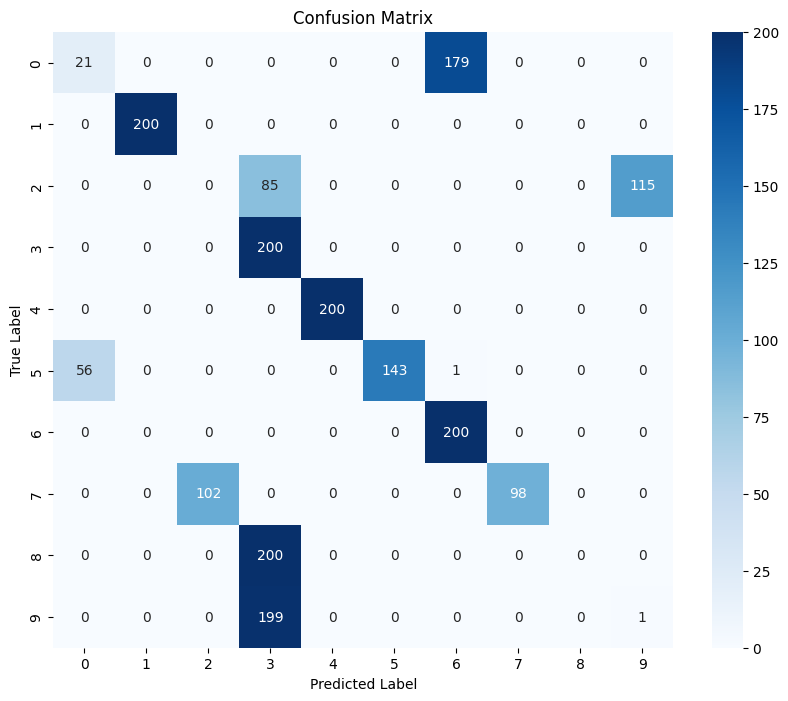

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 预测测试数据集
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels, predicted_classes, target_names=[str(i) for i in range(10)])  # 假设有10个类别
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()